In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

In [2]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    
    classif=np.unique(np.array(y))
    fullmat=np.concatenate((X,y),axis=1)
    means=np.zeros((np.size(X,axis=1),np.size(classif)))
    covmat=np.zeros((np.size(X,axis=1),np.size(X,axis=1)))

    for k in range(np.size(classif)):
        for d in range(np.size(X,axis=1)):
            means[d,k]=np.mean(fullmat[np.where(np.array(y)==classif[k])[0],d])
      
    for i in range(np.size(X,axis=1)):
        for j in range(np.size(X,axis=1)):
            imean=np.mean(X[:,i])
            jmean=np.mean(X[:,j])
            covmat[i,j]=np.sum(np.multiply((X[:,i]-imean),(X[:,j]-jmean)))/(np.size(X,axis=0))

    return means,covmat

In [3]:
def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    classif=np.unique(np.array(y))
    fullmat=np.concatenate((X,y),axis=1)
    means=np.zeros((np.size(X,axis=1),np.size(classif)))
    covmats=list()

    for k in range(np.size(classif)):
        for d in range(np.size(X,axis=1)):
            means[d,k]=np.mean(fullmat[np.where(np.array(y)==classif[k])[0],d])
                    
        classmat=fullmat[np.where(np.array(y)==classif[k])[0],:-1]

        covmatd=np.zeros((np.size(classmat,axis=1),np.size(classmat,axis=1)))
        for i in range(np.size(classmat,axis=1)):
            for j in range(np.size(classmat,axis=1)):
                imean=np.mean(classmat[:,i])
                jmean=np.mean(classmat[:,j])
                covmatd[i,j]=np.sum(np.multiply((classmat[:,i]-imean),(classmat[:,j]-jmean)))/(np.size(classmat,axis=0))
        
        covmats.append(covmatd)
        
    return means,covmats

In [4]:
def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    cprior=1/np.size(means,axis=1)
    
    probc=np.zeros((np.size(Xtest,axis=0),np.size(means,axis=1)))
    for c in range(np.size(means,axis=1)):
        gc=np.matmul(np.matmul(means[:,[c]].T,inv(covmat)),means[:,[c]])+np.log(cprior)
        betac=np.matmul(inv(covmat),means[:,[c]])
        probc[:,[c]]=(betac.T @ Xtest.T+gc).T
        
    
    ypred=np.argmax(probc,axis=1)
    acc=np.mean(ypred==ytest.T)
        
    return acc,ypred

In [5]:
def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    cprior=1/np.size(means,axis=1)
    
    probc=np.zeros((np.size(Xtest,axis=0),np.size(means,axis=1)))
    for c in range(np.size(means,axis=1)):
        gc=np.matmul(np.matmul(means[:,[c]].T,inv(covmats[c])),means[:,[c]])+np.log(cprior)
        betac=np.matmul(inv(covmats[c]),means[:,[c]])
        probc[:,[c]]=(betac.T @ Xtest.T+gc).T
        
    ypred=np.argmax(probc,axis=1)
    acc=np.mean(ypred==ytest.T)

    return acc,ypred

In [6]:
def learnOLERegression(X,y):
    # Inputs:                                                         
    # X = N x d 
    # y = N x 1                                                               
    # Output: 
    # w = d x 1 
    
    w=np.matmul(np.matmul(inv(np.matmul(X.T,X)),X.T),y)
    return w

In [7]:
def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1                                                                

   # for d in range(np.size(X,axis=1)):
   #     X[:,d]=X[:,d]-np.mean(X[:,d])
    
   # y[:,0]=y[:,0]-np.mean(y[:,0])
        
    I=np.identity(np.size(X,axis=1))
                                            
    w=np.matmul(np.matmul(inv(np.matmul(X.T,X)+lambd*I),X.T),y)

    return w

In [8]:
def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse
    
    ypred=np.dot(Xtest,w)
    mse=np.mean(np.power((ytest-ypred),2))
    return mse

In [9]:
def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda                                                                  
    Xw=X @ w
    error = (1/2)*((y-Xw).T @ (y-Xw))+(1/2)*lambd*(np.sum(np.square(w)))
    error_grad= (1/2)*(X.T @ (y-Xw))
    return error, error_grad.flatten()

In [10]:
def mapNonLinear(x,p):
    # Inputs:                                                                  
    # x - a single column vector (N x 1)                                       
    # p - integer (>= 0)                                                       
    # Outputs:                                                                 
    # Xp - (N x (p+1)) 
    
    Xp=np.ones((np.size(x,axis=0),1))
    
    for i in range(1,p+1):
        Xp=np.hstack((Xp,np.power(x,i).reshape((x.shape[0],1))))
        
    return Xp


LDA Accuracy = 0.24
QDA Accuracy = 0.24


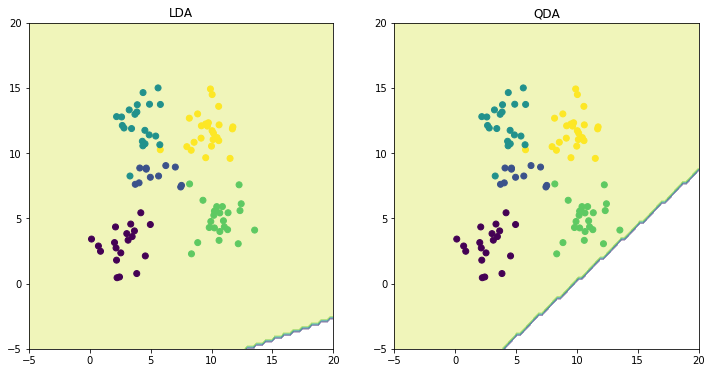

In [11]:
# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.ravel())
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.ravel())
plt.title('QDA')

plt.show()

In [12]:
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

MSE without intercept 106775.36155354623
MSE with intercept 3707.8401817711774


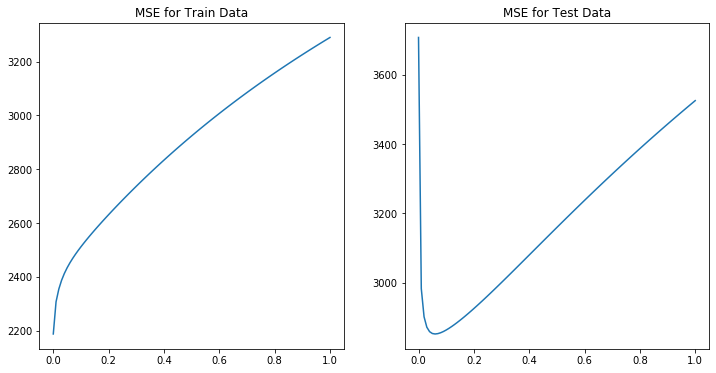

In [13]:
# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

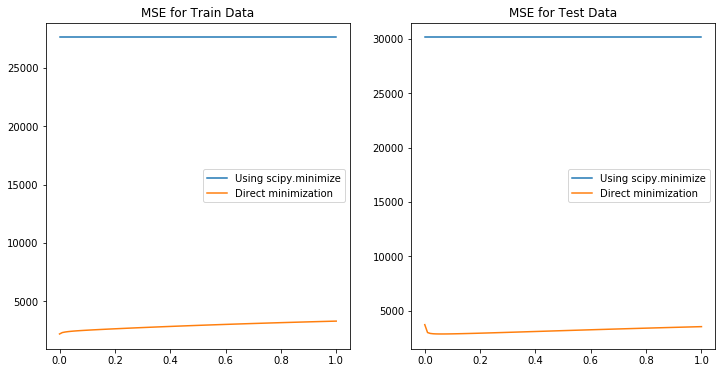

In [14]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y.flatten(), lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()


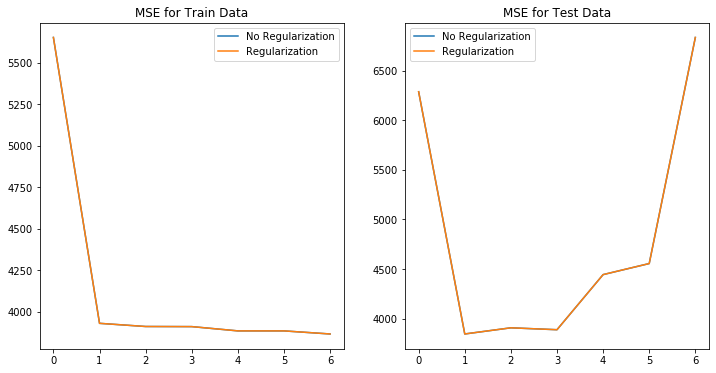

In [15]:
# Problem 5
pmax = 7
lambda_opt = 0 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()